In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

from scipy.stats import zscore
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
data.columns = ["ID","Age","Experience","Income","ZIPCode","Family","CCAvg","Education","Mortgage","PersonalLoan","SecuritiesAccount","CDAccount","Online","CreditCard"]

In [ ]:
data.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [5]:
data.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount',
       'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

The variable "ID" does not add any interesting information. There is no connection between a person's customer ID and loan. Therefore we can neglect this information for our model prediction.

The binary category have five variables:Personal Loan,Securities Account, CD Account, Online and Credit Card.

Interval variables are Age, Experience, Income, CCAvg, Mortage

Ordinal Categorical Variables are: Family & Education

The nominal variables are ID and Zip Code

In [7]:
data.shape

(5000, 14)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5000 non-null   int64  
 1   Age                5000 non-null   int64  
 2   Experience         5000 non-null   int64  
 3   Income             5000 non-null   int64  
 4   ZIPCode            5000 non-null   int64  
 5   Family             5000 non-null   int64  
 6   CCAvg              5000 non-null   float64
 7   Education          5000 non-null   int64  
 8   Mortgage           5000 non-null   int64  
 9   PersonalLoan       5000 non-null   int64  
 10  SecuritiesAccount  5000 non-null   int64  
 11  CDAccount          5000 non-null   int64  
 12  Online             5000 non-null   int64  
 13  CreditCard         5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [9]:
data.apply(lambda x : sum(x.isnull()))
#None of the columns have null data in the file

ID                   0
Age                  0
Experience           0
Income               0
ZIPCode              0
Family               0
CCAvg                0
Education            0
Mortgage             0
PersonalLoan         0
SecuritiesAccount    0
CDAccount            0
Online               0
CreditCard           0
dtype: int64

In [10]:
data.describe().transpose()
#Data Eyeballing

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [11]:
data.apply(lambda x: len(x.unique()))
#finding unique data

ID                   5000
Age                    45
Experience             47
Income                162
ZIPCode               467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
PersonalLoan            2
SecuritiesAccount       2
CDAccount               2
Online                  2
CreditCard              2
dtype: int64

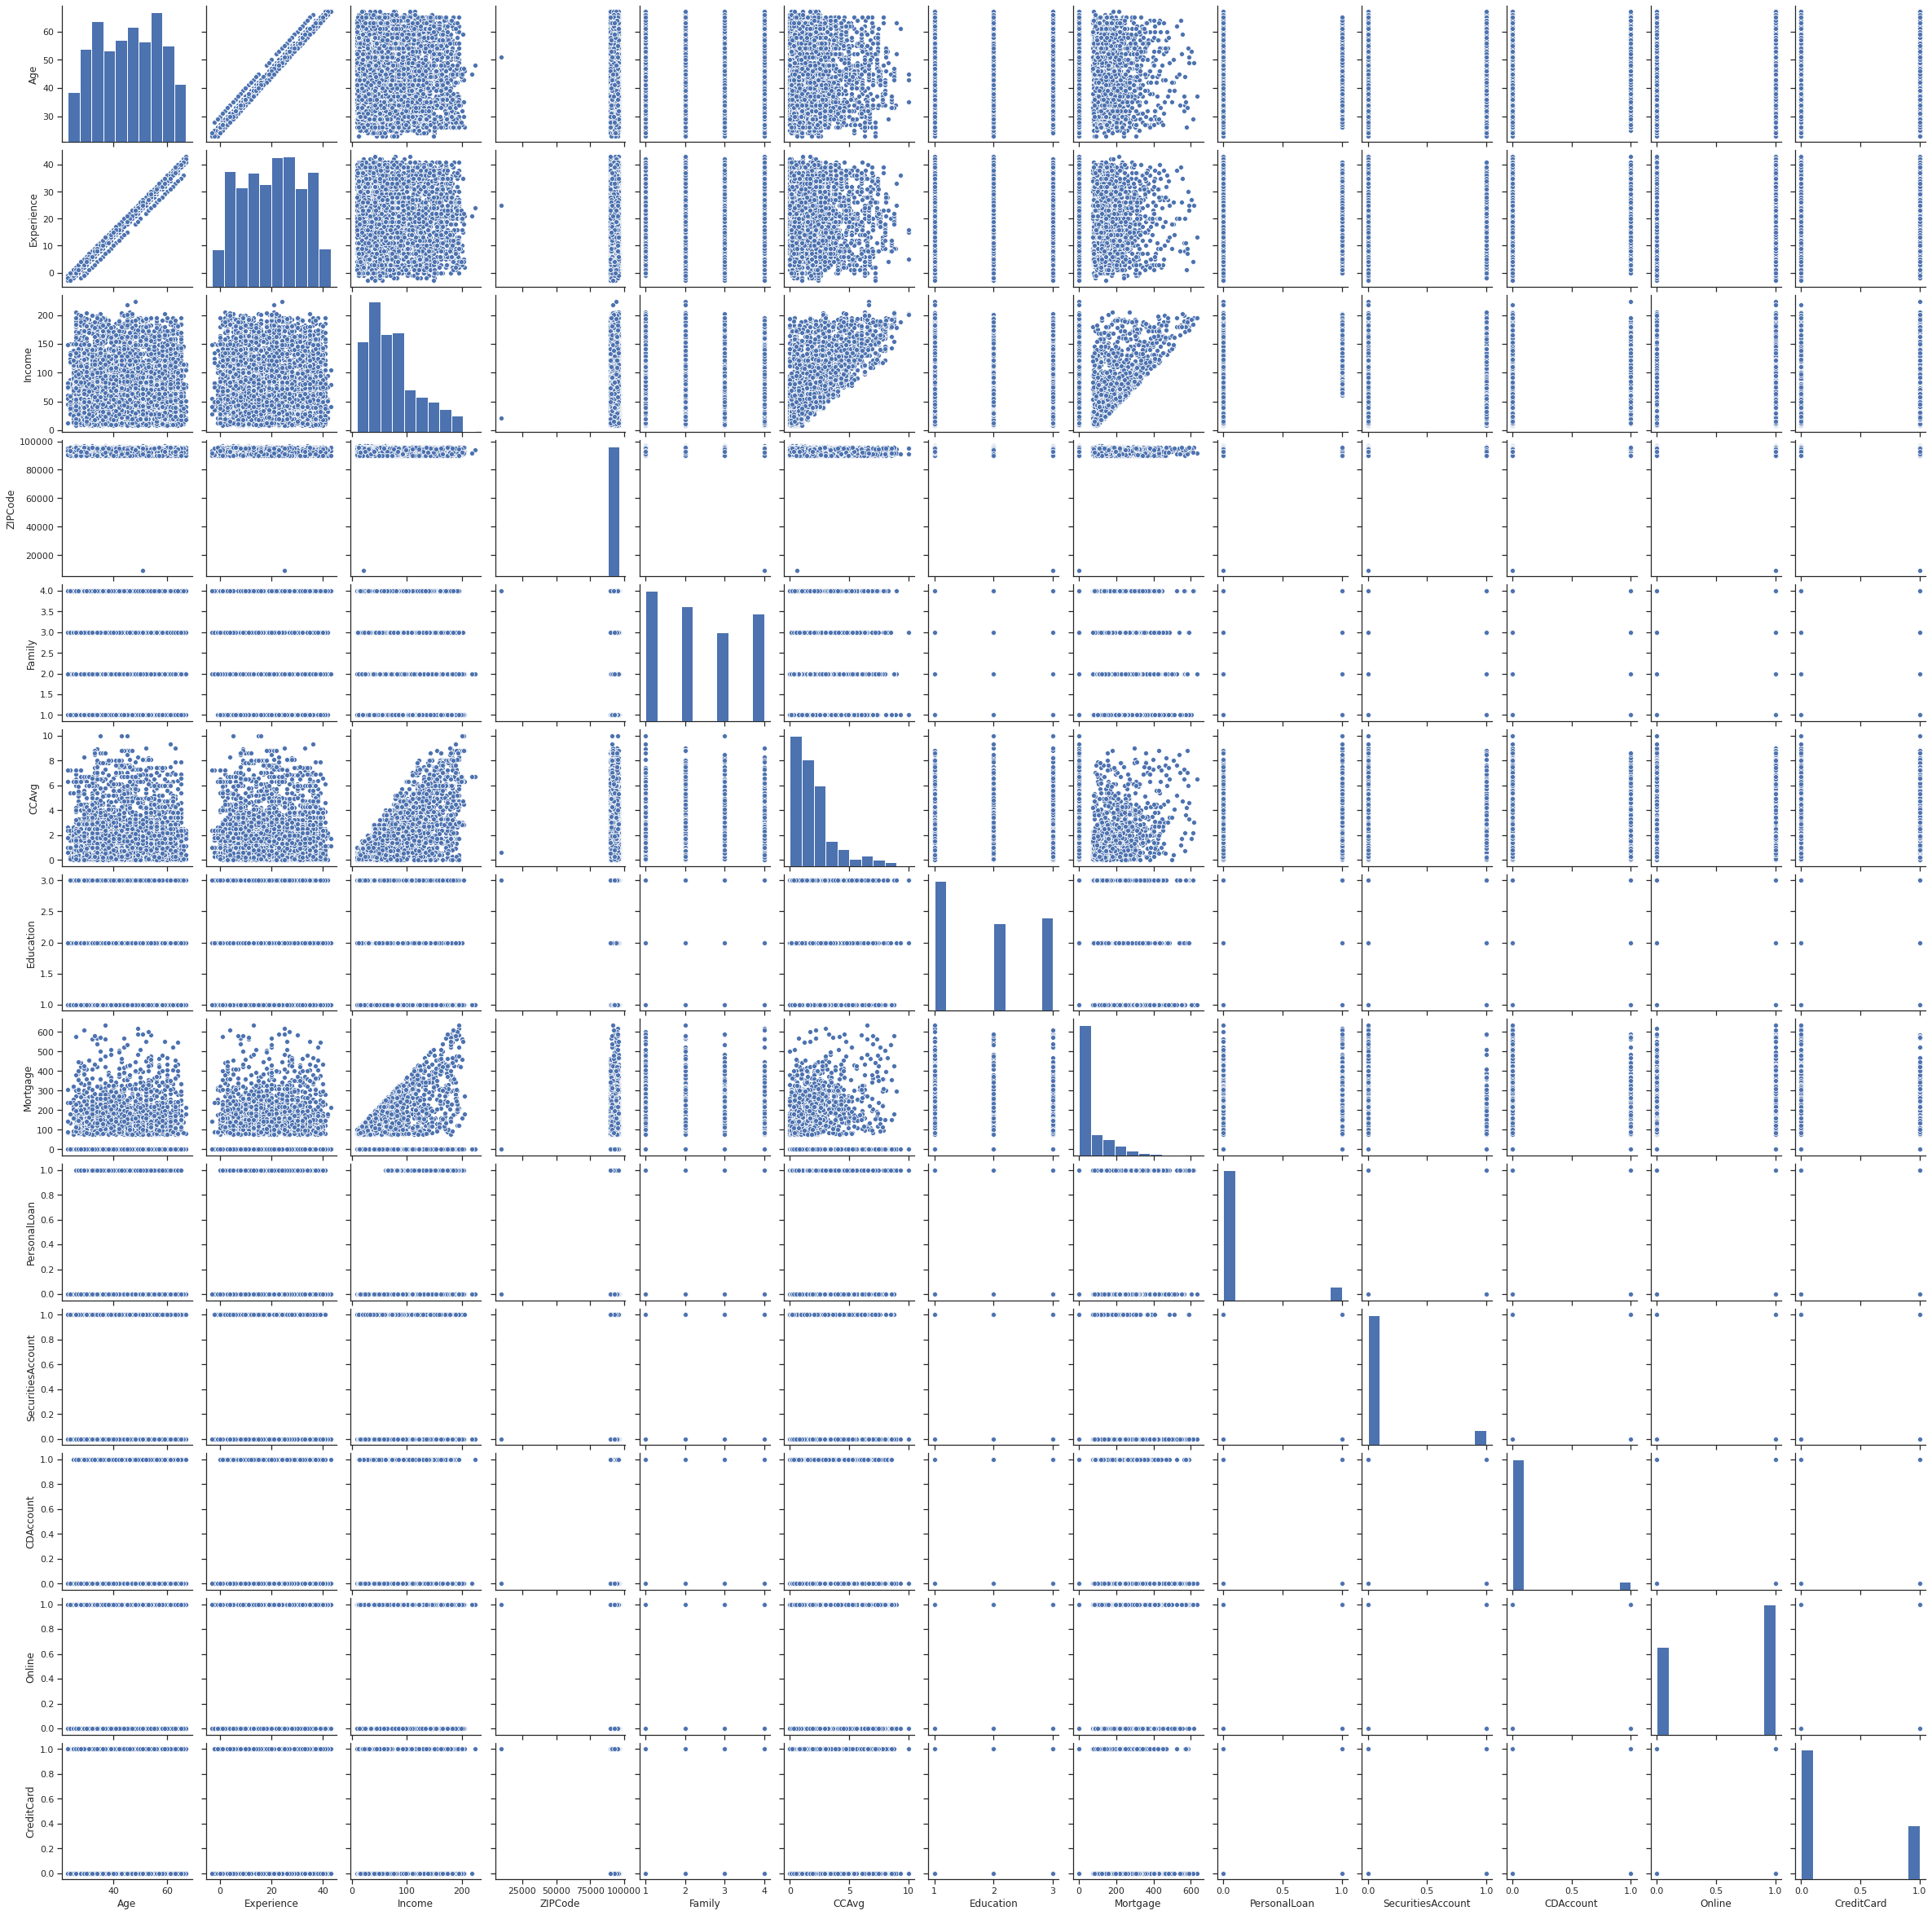

In [12]:
sns.pairplot(data.iloc[:,1:])

Age feature is normally distributed with majority of customers falling between 30-60 years of age. We can confirm this by looking at the statement above, which shows mean is almost equal to median.

Experience is normally distributed with more customer having experience starting from 8 years. Here the mean is equal to median. There are negative values in the Experience. This could be a data input error as in general it is not possible to measure negative years of experience. We can delete these values, because we have 3 or 4 records from the sample.

Income is positively skewed. Majority of the customers have income between 45K and 55K. We can confirm this by saying the mean is greater than the median

CCAvg is also a positively skewed variable and average spending is between 0K to 10K and majority spends less than 2.5K

Mortgage 70% of the individuals have a mortgage of less than 40K. However the max value is 635K

The variables family and education are ordinal variables. The distribution of families is evenly distributes.

In [13]:
data[data['Experience'] < 0]['Experience'].count()
#checking for records with negative experience

52

In [14]:
#cleaning the negative vaariables
dfExp = data.loc[data['Experience'] >0]
negExp = data.Experience < 0
column_name = 'Experience'
mylist = data.loc[negExp]['ID'].tolist()

In [16]:
negExp.value_counts()

False    4948
True       52
Name: Experience, dtype: int64

In [17]:
for id in mylist:
    age = data.loc[np.where(data['ID']==id)]["Age"].tolist()[0]
    education = data.loc[np.where(data['ID']==id)]["Education"].tolist()[0]
    df_filtered = dfExp[(dfExp.Age == age) & (dfExp.Education == education)]
    exp = df_filtered['Experience'].median()
    data.loc[data.loc[np.where(data['ID']==id)].index, 'Experience'] = exp

The above code does the below steps:



*   For the record with the ID, get the value of Age column
*   For the record with the ID, get the value of `Education` column
*   Filter the records matching the above criteria from the data frame which has records with positive experience and take the median
*   Apply the median back to the location which had negative experience





In [18]:
# rechecking if there are records with negative experience
data[data['Experience'] < 0]['Experience'].count()

0

In [19]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,4971.0,20.243211,11.359189,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


**Influence of income and education on personal loan**

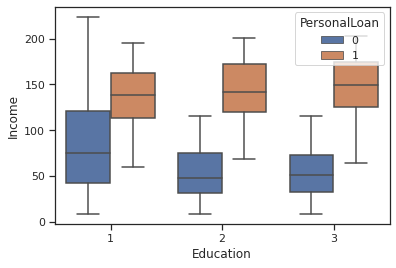

In [20]:
sns.boxplot(x='Education',y='Income',hue='PersonalLoan',data=data)

We observe that customers whose education level is 1 is having more income. However customers who has taken the personal loan have the same income levels

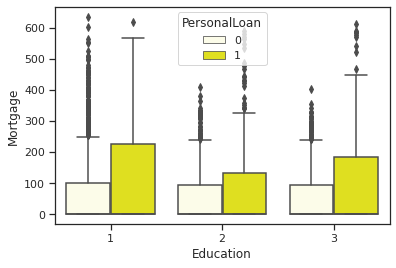

In [21]:
sns.boxplot(x="Education", y='Mortgage', hue="PersonalLoan", data=data,color='yellow')

From the above chart it seems that customer who do not have personal loan and customer who has personal loan have high mortgage.

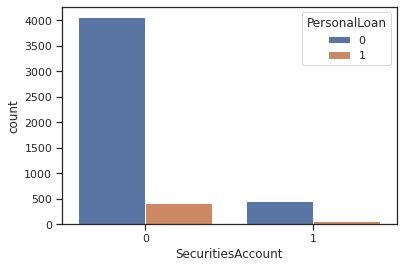

In [22]:
sns.countplot(x="SecuritiesAccount", data=data,hue="PersonalLoan")

We observe that majority of customers who does not have loan have securities account.

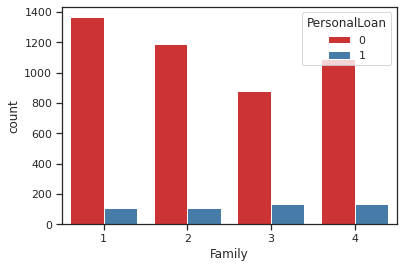

In [23]:
sns.countplot(x='Family',data=data,hue='PersonalLoan',palette='Set1')

We can see thay the family size does not have any impact in personal loan. But it seems families with size of 3 are more likely to take loan. When considering future campaign this might be good association.

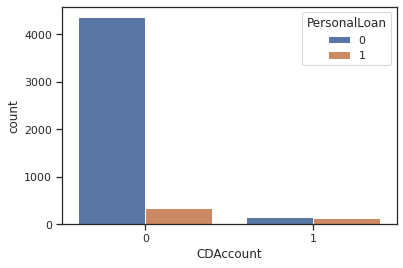

In [24]:
sns.countplot(x='CDAccount',data=data,hue='PersonalLoan')

The customers who does not have CD account do not have loan as well. This seems to be majority. But almost all customers who has CD account has loan as well.

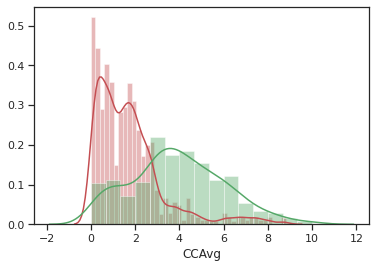

In [25]:
sns.distplot( data[data.PersonalLoan == 0]['CCAvg'], color = 'r')
sns.distplot( data[data.PersonalLoan == 1]['CCAvg'], color = 'g')

In [26]:
print('Credit card expenditure of customers without loan: ',data[data.PersonalLoan == 0]['CCAvg'].median()*1000)
print('Credit card expenditure of customers with loan: ', data[data.PersonalLoan == 1]['CCAvg'].median()*1000)

Credit card expenditure of customers without loan:  1400.0
Credit card expenditure of customers with loan:  3800.0


The graph show persons who have personal loan have a higher credit card average. Average credit card spending with a median of 3800 dollar indicates a higher probability of personal loan. Lower credit card spending with a median of 1400 dollars is less likely to take a loan. This could be useful information.

Text(0, 0.5, 'Age')

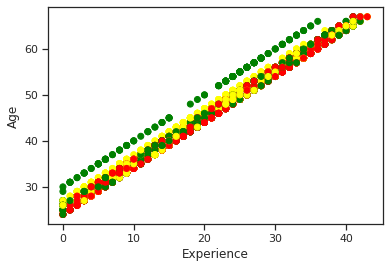

In [27]:
fig, ax = plot.subplots()
colors = {1:'red',2:'yellow',3:'green'}
ax.scatter(data['Experience'],data['Age'],c=data['Education'].apply(lambda x:colors[x]))
plot.xlabel('Experience')
plot.ylabel('Age')

The above plot show with experience and age have a positive correlation. As experience increase age also increases. Also the colors show the education level. There is gap in the mid forties of age and also more people in the under graduate level

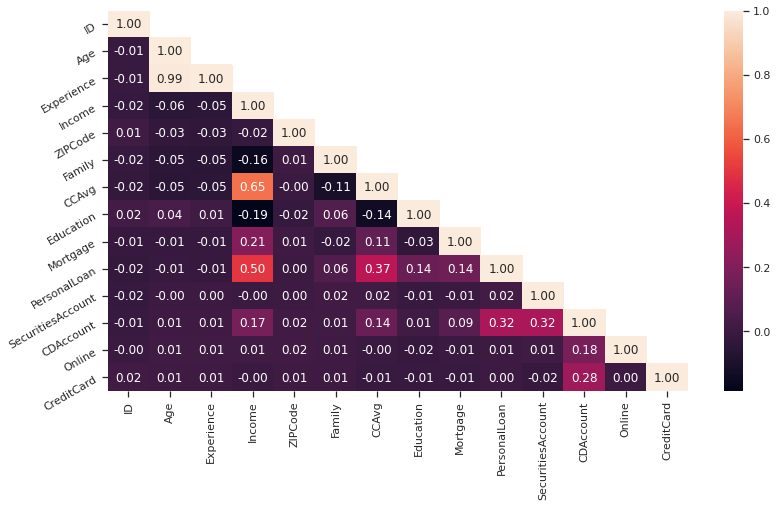

In [32]:
# Correlation with heat map
import matplotlib.pyplot as plt
import seaborn as sns
corr = data.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

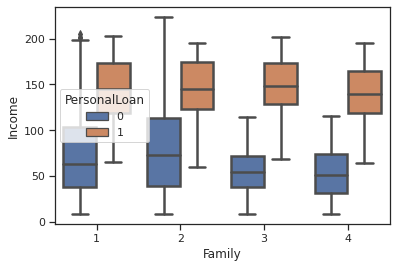

In [33]:
sns.boxplot(x=data.Family,y=data.Income,hue=data.PersonalLoan)

Looking at the above plot, families with income less than 100K are less likely to take loan,than families with high income

**Split data into train and test**

In [34]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data.drop(['ID','Experience'], axis=1), test_size=0.3 , random_state=100)

In [35]:
train_labels = train_set.pop('PersonalLoan')
test_labels = test_set.pop('PersonalLoan')

**Decision tree classifier**

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dt_model=DecisionTreeClassifier(criterion = 'entropy',max_depth=3)
dt_model.fit(train_set, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
dt_model.score(test_set , test_labels)

0.9773333333333334

In [38]:
y_predict = dt_model.predict(test_set)
y_predict[:5]

array([0, 0, 0, 0, 0])

In [39]:
test_set.head(5)

,Age,Income,ZIPCode,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
789,29,31,92126,4,0.3,2,0,0,0,1,0
2507,59,60,90048,4,2.1,1,234,0,0,1,1
2376,58,23,91768,3,0.2,1,0,0,0,0,0
1378,54,34,93305,4,0.1,3,0,0,0,1,0
598,56,11,92374,2,0.2,3,90,0,0,0,0


**Naive Bayes**

In [40]:
naive_model = GaussianNB()
naive_model.fit(train_set, train_labels)

prediction = naive_model.predict(test_set)
naive_model.score(test_set,test_labels)

0.8866666666666667

**Random Forest Classifier**

In [41]:
randomforest_model = RandomForestClassifier(max_depth=2, random_state=0)
randomforest_model.fit(train_set, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

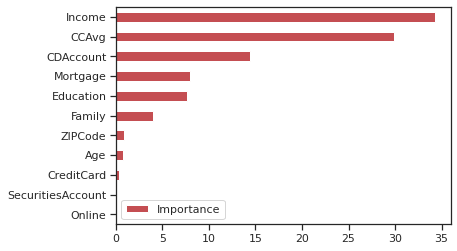

In [42]:
Importance = pd.DataFrame({'Importance':randomforest_model.feature_importances_*100}, index=train_set.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )

In [43]:
predicted_random=randomforest_model.predict(test_set)
randomforest_model.score(test_set,test_labels)

0.904

**K - Nearest Neighbour**

In [44]:
train_set_indep = data.drop(['Experience' ,'ID'] , axis = 1).drop(labels= "PersonalLoan" , axis = 1)
train_set_dep = data["PersonalLoan"]
X = np.array(train_set_indep)
Y = np.array(train_set_dep)
X_Train = X[ :3500, :]
X_Test = X[3501: , :]
Y_Train = Y[:3500, ]
Y_Test = Y[3501:, ]

In [45]:
knn = KNeighborsClassifier(n_neighbors= 21 , weights = 'uniform', metric='euclidean')
knn.fit(X_Train, Y_Train)    
predicted = knn.predict(X_Test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y_Test, predicted)
print(acc)

0.9106070713809206


**Model comparison**

In [46]:
X=data.drop(['PersonalLoan','Experience','ID'],axis=1)
y=data.pop('PersonalLoan')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.898600 (0.008902)
CART: 0.982400 (0.004363)
NB: 0.885600 (0.010385)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.987000 (0.003924)


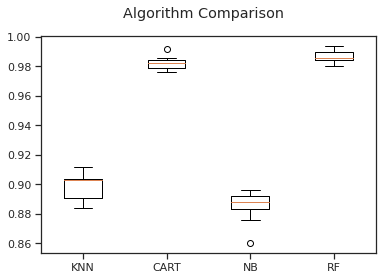

In [47]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=12345)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Conclusion**
The aim of the universal bank is to convert there liability customers into loan customers. They want to set up a new marketing campaign; hence, they need information about the connection between the variables given in the data. Four classification algorithms were used in this study. From the above graph , it seems like Decision Tree algorithm have the highest accuracy and we can choose that as our final model